## Custom Market Indices Using Fundamental and Technical Data

In this tutorial we use fundamental and technical (price-volume) data to construct a custom index. As an example, we aim at constructing a proxy of Russell 2000, that is, an index composed of 2000 smallest stocks in the US equity markets. The methodology presented below is easy to extend to more complex indices which rely on fundamental data and technical data.
The main bulk of official rules for constructing the R2000 index are as follows:

1. US based,
2. Trade on an eligible US exchange,
3. Have a minimum price of 1 dollar on the day of constructing the index,
4. Have a market capitalization of no less than 30 million dollars,
5. Minimum of 5% of the float available,
6. Companies structured in the following ways are excluded: royalty trusts, U.S. limited liability companies, closed-   end investment companies.

We will only approximate this set of rules as we proceed. We study the portfolio over 2000-2020 and contrast it against IWM, an exchange traded fund corresponding to the R2000. Note that in reality the selection for the index is done only once per year, however, we use quarterly data and refresh the set of constituents four times a year. In addition to this, we include ADRs into the mix which are not a part of the official methodology. 

In [2]:
import pandas as pd
import xxx as cru
from copy import deepcopy
from xxx import get_db_conn
import pandas_datareader as pdr

### Importing the data

We begin by importing data. For obvious reasons, the important parameters have been censored. The main idea is to show that we import fundamental data for the US equity markets from a proprietary SQL database. The technical data on the other hand is stored in parquet files in a proprietary database. Parquet files have become exceedingly popular due to their efficiency with respect to reading, writing, and storing capacity. Parquet is part of an Apache project and thus geared for big data applications.

In [ ]:
# Fundamental data
fund_table = pd.read_csv(\'Fundamental_Variables_Q.csv')
col_dict = dict(fund_table[['Field name', 'Variable']].values)
conn = get_db_conn(database = 'xxx',
                username = 'xxx',
                password = 'xxx' ,
                server='xxx',
                driver_version=17,
                is_sqlalchemy=True)

query_1 = '''
            SELECT
                ff_eps_rpt_date as date,      
                {fields},
                LEFT(ticker_region, LEN(ticker_region) - 3) AS ticker_region
            FROM QData.Fundamentals
            WHERE date >= '{x}'
                  AND date <= '{y}'
                  AND ticker_region NOT IN
                      (
                          SELECT ticker_region FROM QData.REITs
                      )
                  AND RIGHT(ticker_region, 3) = '-US';
        '''
fund_q = pd.read_sql_query(query_1.format(x='2000-01-01',
                                      y='2030-01-01',
                                      fields=', '.join(list(fund_table['Field name'].dropna()))),
                       conn,
                       parse_dates=['date']).rename(columns=col_dict)
fund_q = fund_q.set_index(pd.to_datetime(fund_q.date_EPS_rep))
fund_q.sort_index(ascending=True, inplace=True)
fund_q['quarter'] = pd.PeriodIndex(fund_q.date, freq='Q').to_timestamp()
fund_q.rename(columns={'ticker_region':'ticker'}, inplace=True)


# Technical data
data = []
for i in range(2000, 2021):
    df = cru.get_adls_parquet_data(adls_path='latest_data/joined-view/year=%s'%i,
                                     acct_name='xxx',
                                     acct_key='xxx',
                                     azcopy_exe=r'xxx',
                                     file_system='quant-filesystem')
    data.append(df)
data = pd.concat(data, axis=0)
data = data.set_index(pd.to_datetime(data['date']))
data.sort_index(ascending=True, inplace=True)
prices = data[(data.type == 'SHARE') |
              (data.type == 'ADR')]
prices['quarter'] = pd.PeriodIndex(prices.index, freq='Q').to_timestamp()

### Selecting R2000 tickers

Below we sample the R2000 tickers from the fundamental data, compute weights for each ticker for each quarter, and store the data into a pd.DataFrame. We approximate the index constituents at this point by adding two rules in addition to basic bottom-2000-rule. Namely, the market value of the company must be at least 30 million USD (below market value is stored in millions), and the ticker symbol has to be of maximum length of four characters. This way we exclude constituents which naturally do not belong into a stock market index. 

As for the datetime index, we are careful to use the release date of the quarterly report. More precisely, we use the date when the earnings-per-share was first reported. An important move is to push the information released at a given quarter into the next. This will assure that we do not introduce look-ahead-bias into the portfolio. 

In [16]:
# Add vol and price data into fund_d
fund_q_t = dict(list(fund_q.groupby('ticker')))
prices_t = dict(list(prices.groupby('ticker')))

fund = {}
for k in fund_q_t.keys():
    if (len(k) <= 4) & (k in prices_t.keys()):
    
        df_1 = fund_q_t[k]
        df_2 = prices_t[k]
        df_2.set_index(df_2.quarter, inplace=True)
        
        q_vol = df_2['vol'].groupby(level=0).median()
        q_price = df_2['close'].groupby(level=0).first()
        
        df_2 = pd.concat([q_vol, q_price], axis=1)
        
        df_1 = df_1.merge(df_2, on=['quarter']).set_index('date_EPS_rep', drop=False)     
        df_1 = df_1[(df_1['Market_value'] >= 30) & (df_1['vol'] >= 150) & (df_1['close'] >= 1)]
        
        if df_1.shape[0] > 0:
            fund[k] = df_1

fund = pd.concat(fund)

fund = fund.groupby('quarter').apply(lambda x: x.drop_duplicates('ticker').sort_values('Market_value', ascending=True).head(2000)).set_index('date_EPS_rep', drop=False)
ind_value = pd.DataFrame(fund.groupby('quarter').apply(lambda x: x['Market_value'].sum()), columns=['ind_value'])
fund = fund.merge(ind_value, on=['quarter']).set_index('date_EPS_rep', drop=False)
fund['weight'] = fund['Market_value'] / fund['ind_value']

fund['quarter_index'] = fund['quarter'] + pd.DateOffset(months=3)

### Formatting price data and merging with fundamental data

The main point of contact between the fundamental data and the technical data are the ticker and the datetime (when the fundamental data was first reported). 

In [24]:
pct_change = prices.groupby('ticker').apply(lambda x: x.close.pct_change())
pct_change = pct_change.reset_index().set_index('date_i', drop=True)
pct_change.rename(columns={'close':'pct_change'}, inplace=True)

prices.index.name = 'date_i'

prices = pd.merge(prices, pct_change, how='left', on=['ticker', 'date_i'])

price_dict = dict(list(prices.groupby('quarter')))
r2_dict = dict(list(fund.groupby('quarter_index')))

### Construct the index

In addition to belonging to the 2000 smallest companies in terms of market value, we also restrict the median quarterly volume to 150000 shares as well as the closing price of the first day of the quarter to be larger than one.

In [35]:
r2_index = []
r2_port = []
for k in price_dict.keys():
    if k in r2_dict.keys():
        df_1 = price_dict[k]
        df_2 = r2_dict[k]
        
        df_1 = df_1[df_1['ticker'].isin(list(df_2.ticker))]
        df_1 = df_1.merge(df_2[['ticker', 'weight']], on=['ticker']).set_index('date') 
        df_1['w_ret'] = (df_1['weight']*df_1['pct_change']) + 1        
        idx_port = df_1['w_ret'].groupby(level=0).prod()

        r2_index.append(idx_port)

### Contrasting against the IWM ETF



In [38]:
# Import and append IWM into our index dataframe
r2_i = pd.DataFrame(pd.concat(r2_index))
r2_i['IWM'] = pdr.DataReader('IWM', 'yahoo', 2000, 2021).Close.pct_change() +1 
r2_i = r2_i.drop_duplicates().dropna().loc[:'2020-9']

We study the descriptive statistics of the return distributions and realize that distributions are very close to each other. Our R2000 index has a lower mean return, however, it also has significantly lower standard deviation. This explains why the portfolios performance is on par with IWM.

In [59]:
((r2_i-1)*100).describe().round(2)

,Prop_R2000,IWM
count,5118.00,5118.00
mean,0.04,0.03
std,1.40,1.53
min,-12.14,-13.27
25%,-0.52,-0.71
50%,0.07,0.10
75%,0.64,0.83
max,14.87,9.15


Adding dates as an extra dimension represented by a color-code will give additional information when looking at the scatterplot of the two sets of returns. We see that there does not seem to be any type of structural change over time based on the scatterplot. Clearly, we have a lot of volatility at the far end of the date index corresponding to 2020. This should not be surprising given the unprecedented circumstances due to COVID-19.

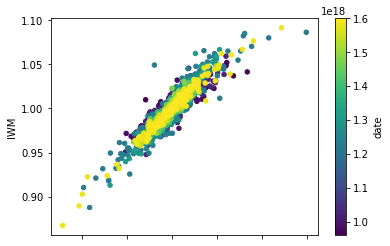

In [61]:
r2_i['date'] = r2_i.index
r2_i.plot.scatter(x='Prop_R2000', y='IWM', c='date', colormap='viridis')

Looking at the performance of the two portfolios will show how closely they move together.

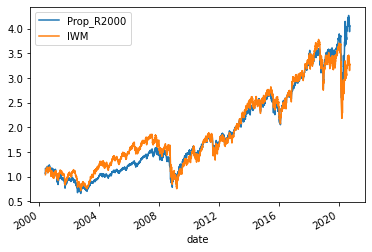

In [67]:
r2_i.cumprod().plot()    

The correlation is clearly high. Let us look at the distribution of yearly correlations to see what the distribution of the correlation coefficients are. This is useful in order to understand how widely the co-movements of the portfolios deviate, and thus gives us a better understanding of the "riskiness" of relying on our proxy.

count    21.00
mean     91.73
std       3.75
min      83.90
25%      90.11
50%      92.06
75%      93.73
max      98.12
Name: Correlations, dtype: float64

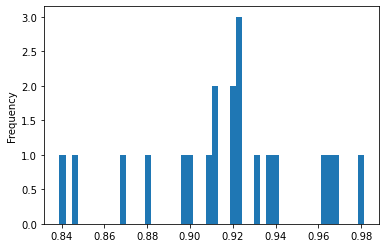

In [68]:
corrs = []
for i in r2_i.resample('A').last().index.year:
    corrs.append(r2_i.loc[str(i)].corr().iloc[0,1])
corrs = pd.Series(corrs, name='Correlations', index=r2_i.resample('A').last().index.year)

corrs.plot.hist(bins=50)
(corrs*100).describe().round(2)

We see that the mean and median are above 90% while the distribution of the correlations is skewed slightly to the left. The standard deviation of the correlations is quite low, which gives us conviction that we can rely on the mean value for future reference, and this distribution is a good representative of the true distribution for the correlations.

In [69]:
(r2_i.corr()*100).round(2)

,Prop_R2000,IWM
Prop_R2000,100.00,91.81
IWM,91.81,100.00


Finally we see that the correlation over the complete dataset is close to 92%. This concludes the tutorial, providing a flexible platform to construct custom indices via fundamental and techincal data. 